In [23]:
import numpy as np
import math
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import truncnorm
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#
import xgboost as xgb

In [24]:
np.random.seed(42)
tf.random.set_seed
n_list = [20, 25]
epochs = {
    n_list[0]: 100,
    n_list[1]: 100
}

In [25]:
def rastrigin(x, n):
    """
    Rastrigin function
    Global minimum: f(x*) = 0 at x* = (0,...,0)
    Search domain: [-5.12, 5.12]^n
    """
    A = 10
    sum = 0.0
    for i in range(n):
        sum += x[i]**2 - A*np.cos(2*np.pi*x[i])
    return A*n + sum

def get_truncated_normal(mean=5, sd=1, low=0, upp=10, size=None):
    """normal distribution between 0 and 10"""
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size)

def generate_x(n, k):
    """
    generate n dimensional normal distribution array in range [-5, 5] (mit gaussian standard!!!)
    n: how many columns to generate
    k : how many rows to generate
    """
    x = np.array([get_truncated_normal(size=k) for _ in range(n)])
    return x

In [26]:
# plot a multidiemensional version of rosenbrock function
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':600, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})


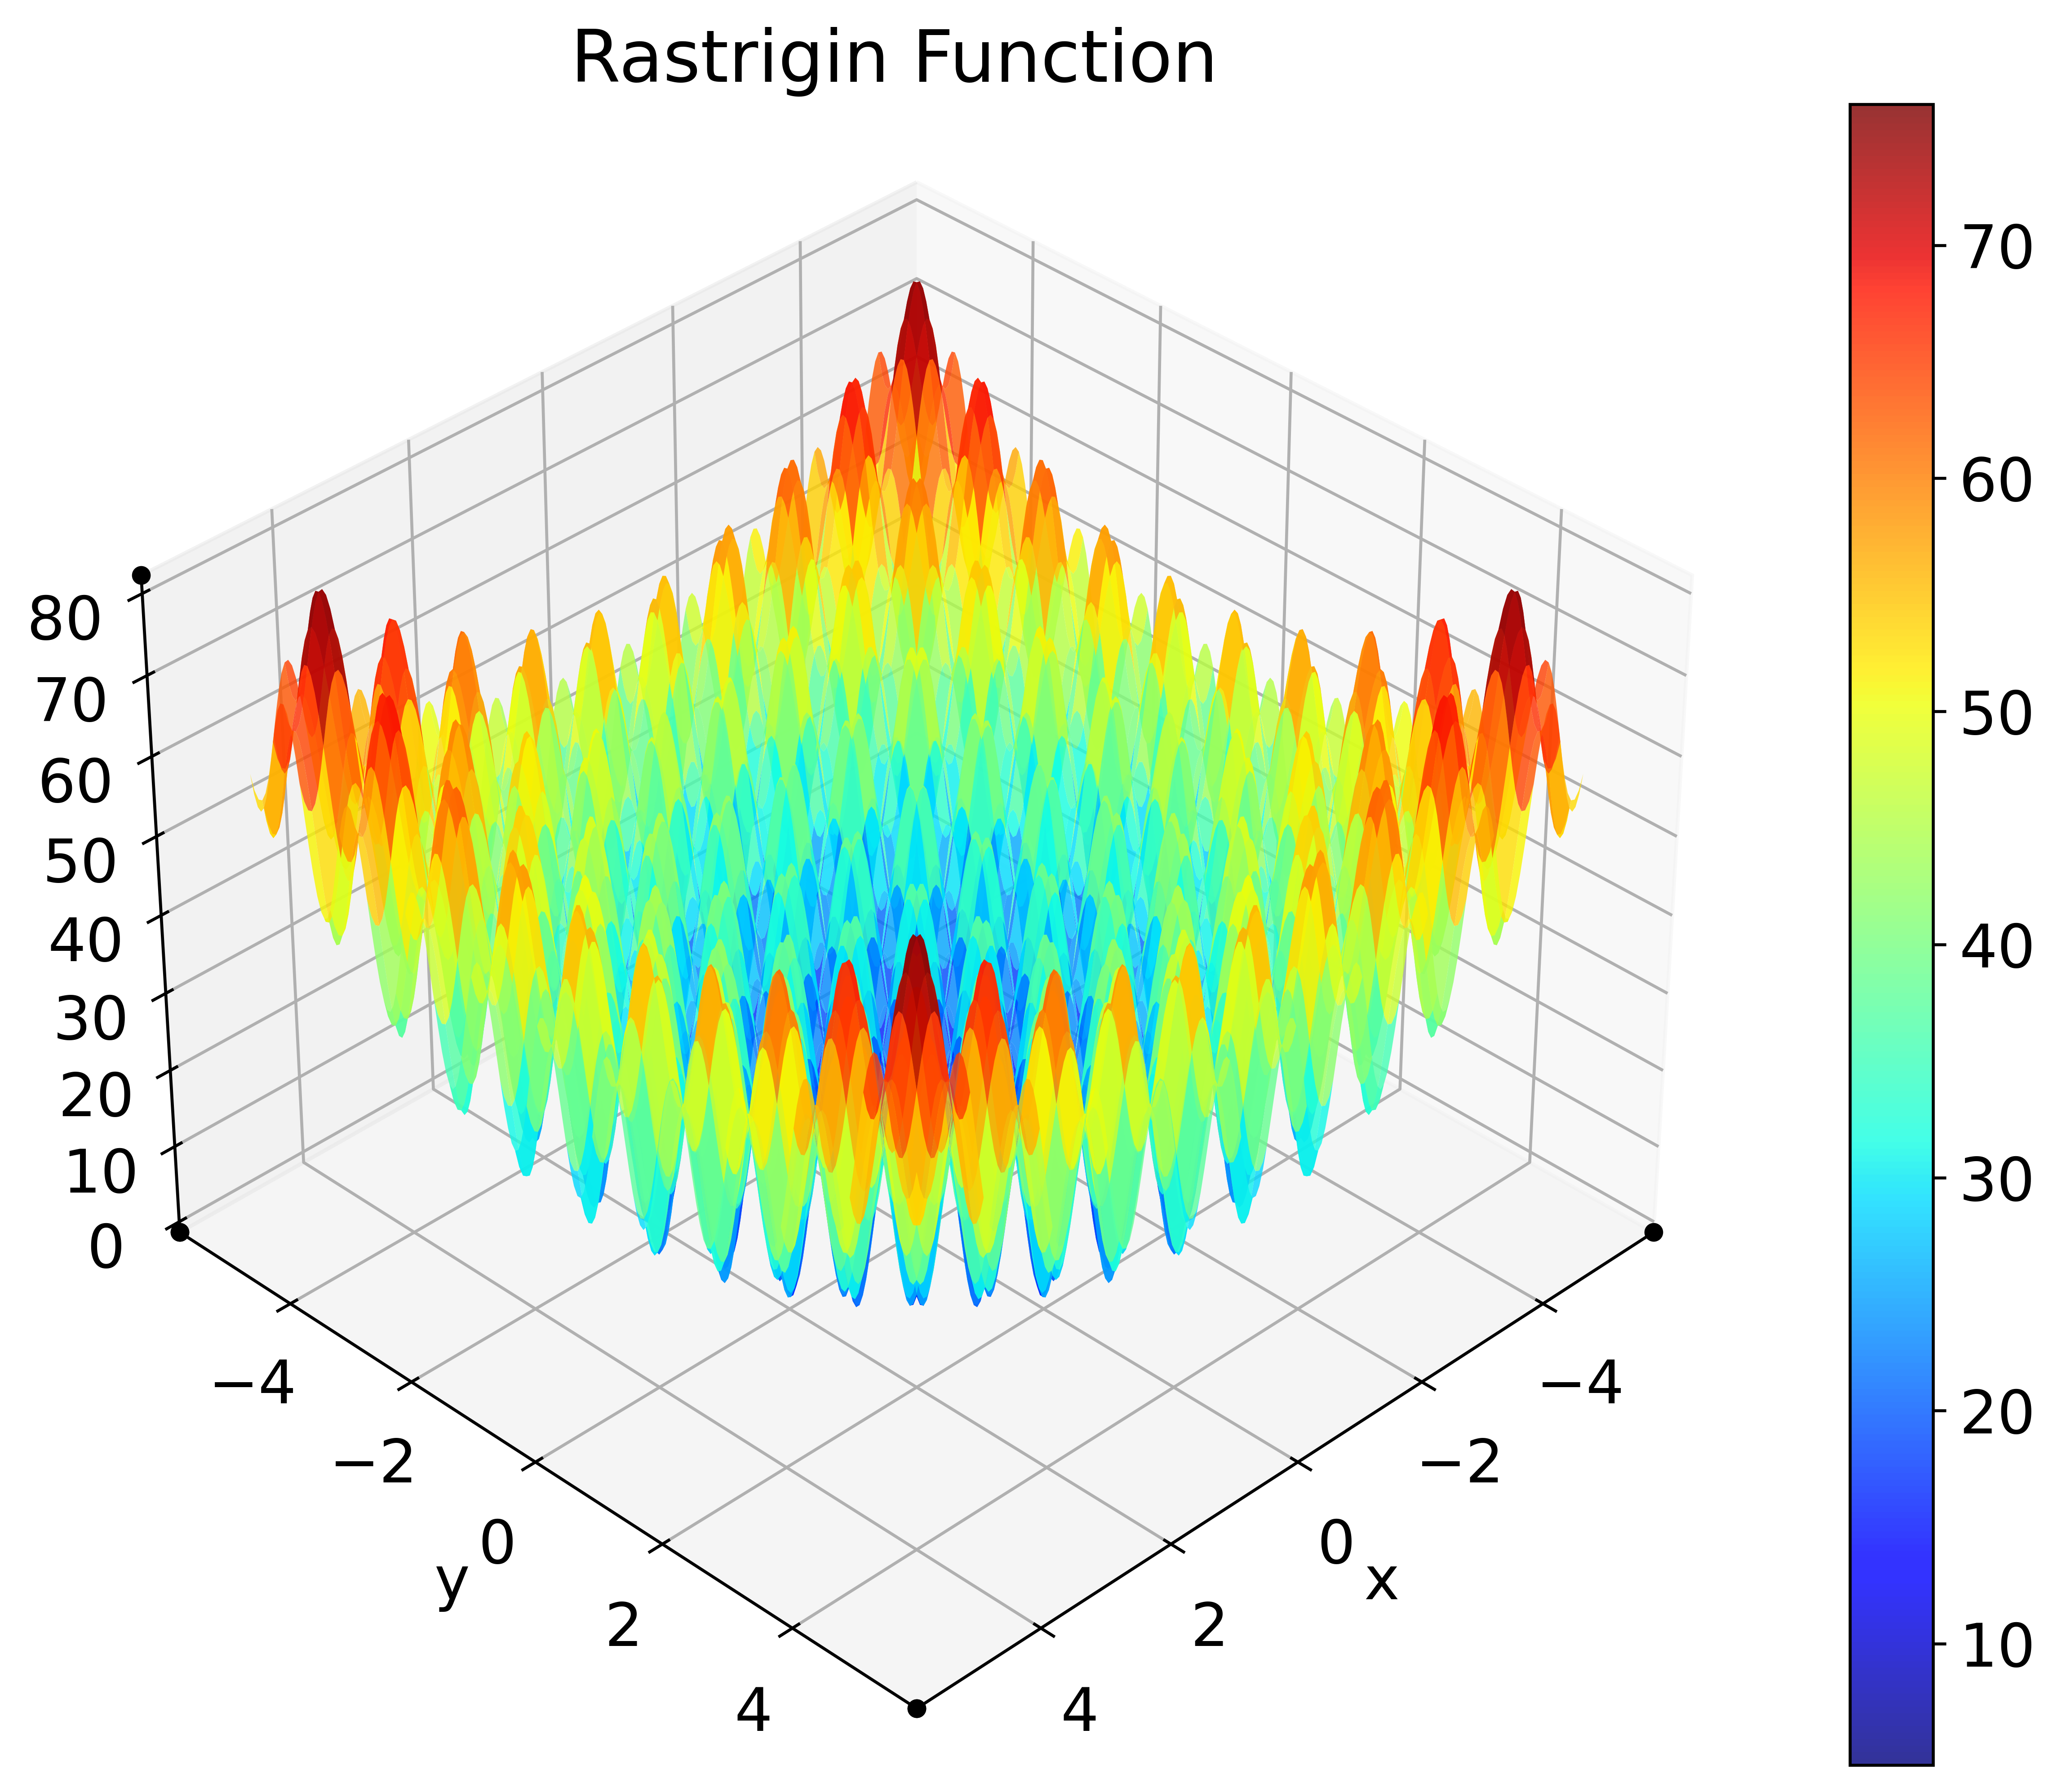

In [28]:
from mpl_toolkits.mplot3d import Axes3D

def rastrigin_2d(x, y):
    """2D Rastrigin function"""
    return 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

# Create coordinate grid
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X, Y = np.meshgrid(x, y)
Z = rastrigin_2d(X, Y)

# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, Z, 
                      cmap='jet',
                      alpha=0.8,
                      antialiased=True)

# Customize plot
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('f(x,y)')
ax.set_title('Rastrigin Function')
plt.colorbar(surf)

# Set viewing angle
ax.view_init(elev=35, azim=45)

In [20]:
def create_data(n, k=200_000, verbose=True):
    X = generate_x(n=n, k=k)
    y = rastrigin(X, n)
    columns_name = [f'x_{i}' for i in range(n)]
    #
    df = pd.DataFrame(X.T, columns=columns_name)
    df["y"] = y
    #
    if verbose:
        df.head()
        df.describe()
    #
    X = df.drop('y', axis = 1)
    y = df['y']
    return X, y

## Train neural network and XGBoost model

In [21]:
def build_and_compile_ann(lr):
    model = keras.Sequential([
      layers.Dense(64, activation='relu'), 
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(lr))
    return model

def train_ann(X_train, y_train, epochs, lr):
    ann_model = build_and_compile_ann(lr)
    history = ann_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=epochs)
    return ann_model, history

def train_xgb(X_train, y_train):
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    xgb_model.fit(X_train, y_train)
    return xgb_model

In [22]:
metadata = {}
for n in n_list:
    X, y = create_data(n)
    X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X, y, test_size=0.1)
    X_train = X_df_train.values
    y_train = y_df_train.values
    #
    print(f"Training models for {n} variables")
    xgb_model = train_xgb(X_train, y_train)
    #lr = 0.001 if n == 10 else 0.01 # learning rate
    ann_model, history = train_ann(X_train, y_train, epochs=epochs[n], lr=0.001)
    #
    y_pred_ann = ann_model.predict(X_df_test)
    y_pred_xgb = xgb_model.predict(X_df_test.values)
    r2_ann = r2_score(y_df_test, y_pred_ann.flatten())
    mse_ann = mean_squared_error(y_df_test, y_pred_ann.flatten())
    r2_xgb = r2_score(y_df_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_df_test, y_pred_xgb)
    print(f"R2 score of ANN ({n} variables): ", r2_ann)
    print(f"R2 score of XGBoost ({n} variables): ", r2_xgb)
    #
    metadata_n = {'ANN_R2': r2_ann,'ANN_MSE':mse_ann, 'XGB_R2': r2_xgb,'XGB_MSE':mse_xgb, 'epochs': epochs[n]}
    metadata[n] = metadata_n
    #
    ann_model.save(f'models/ANN_{n}.h5')
    xgb_model.save_model(f'models/XGB_{n}.json')

with open('models/metadata.json', 'w') as file:
    json.dump(metadata, file)

print("Training complete")

Training models for 20 variables
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


R2 score of ANN (20 variables):  0.6601770786072254
R2 score of XGBoost (20 variables):  0.911405219356788
Training models for 25 variables
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


R2 score of ANN (25 variables):  0.6604793637407667
R2 score of XGBoost (25 variables):  0.8846070943376853
Training complete
